In [1]:
%%capture
# thought upgrading pip would get rid of that progress bar. Whatever. capture got it.
!pip install -q --upgrade pip
!pip install -q PyGLM matplotlib-label-lines pytorch-lightning omegaconf einops kornia

In [2]:
%%capture
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/zacjiang/GMA.git
!git clone https://github.com/shariqfarooq123/AdaBins.git
!git clone https://github.com/CompVis/taming-transformers.git
#!git clone https://github.com/dmarx/pytti.git # oh, this is the modified one... hmm...
!git clone https://github.com/sportsracer48/pytti.git #
!cd pytti; git checkout p5; cd ..

In [4]:
%%capture
!pip install -r CLIP/requirements.txt
# pip install git+https://github.com/openai/CLIP.git # ooh, fancy!
!pip install ./CLIP

In [5]:
!nvidia-smi

Sat Nov 27 20:05:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from dataclasses import dataclass
import sys 

sys.path.append('./AdaBins') # for infer.py in DepthLoss

import pytti
from pytti.Image import VQGANImage
from pytti.Image.VQGANImage import VQGAN_MODEL_NAMES
from pytti.Notebook import load_clip
from pytti.Perceptor.Embedder import HDMultiClipEmbedder
from pytti.ImageGuide import DirectImageGuide
from pytti.Perceptor.Prompt import Prompt, MultiClipImagePrompt, parse_prompt
from pytti.LossAug import TVLoss



In [7]:
@dataclass
class Args:
    prompts = ['a painting of an apple']
    height = 200
    width = 200
    ### chose CLIP backbone ###
    RN50x4 = False
    RN50 = False
    ViTB32 = False
    ViTB16 = True 
    ###########
    _n_steps=10 #100 # 7 minutes on a k80... yeesh
    
params = Args()

In [8]:
%%capture
# probably a better way to do this in notebook.py or something. Also, should be invoking params here
model_idx = 0 # maybe use an enum here
model_name = VQGAN_MODEL_NAMES[model_idx]
VQGANImage.init_vqgan(model_name=model_name)

load_clip(params=params)

In [9]:
img = VQGANImage(width=params.width, height=params.height)
emb = HDMultiClipEmbedder()
guide = DirectImageGuide(image_rep=img, embedder=emb)

prompt = "a painting of an apple"
out = parse_prompt(embedder=emb, prompt_string=prompt)

loss_augs = [TVLoss()] # shouldn't be necessary...


In [10]:
guide.run_steps(
    n_steps=params._n_steps,
    prompts=[out],
    # uh....
    interp_prompts=None, # interpolation?
    loss_augs=loss_augs #None # this can't be None
)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


10

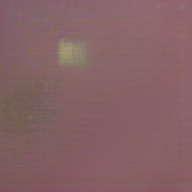

In [11]:
guide.image_rep.decode_image()

In [12]:

torch.cuda.empty_cache()

True

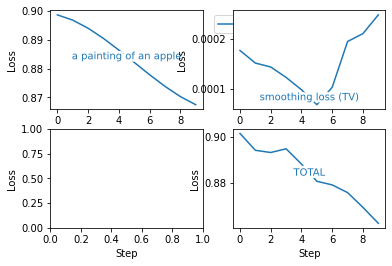

In [13]:
fig, axs = plt.subplots(2,2)
axs = axs[0,0], axs[0,1], axs[1,0], axs[1,1]
guide.plot_losses(axs)